In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [2]:
# Download the dataset
df = yf.download('SPY', start='2010-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Prepare dataset for normalization
dataset = df['Close'].values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))

# Scale the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [4]:
# Split the data into train, validation, and test sets
train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train, val, test = dataset[0:train_size,:], dataset[train_size:(train_size+val_size),:], dataset[(train_size+val_size):len(dataset),:]


In [5]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [6]:
# Reshape into X=t and Y=t+1
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_val, y_val = create_dataset(val, look_back)
X_test, y_test = create_dataset(test, look_back)

In [7]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [8]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/100
64/64 [==============================] - 1s 4ms/step - loss: 0.0172 - val_loss: 0.0912
Epoch 2/100
64/64 [==============================] - 0s 1ms/step - loss: 0.0099 - val_loss: 0.0624
Epoch 3/100
64/64 [==============================] - 0s 965us/step - loss: 0.0103 - val_loss: 0.0529
Epoch 4/100
64/64 [==============================] - 0s 957us/step - loss: 0.0100 - val_loss: 0.0474
Epoch 5/100
64/64 [==============================] - 0s 930us/step - loss: 0.0093 - val_loss: 0.0426
Epoch 6/100
64/64 [==============================] - 0s 930us/step - loss: 0.0085 - val_loss: 0.0379
Epoch 7/100
64/64 [==============================] - 0s 939us/step - loss: 0.0078 - val_loss: 0.0333
Epoch 8/100
64/64 [==============================] - 0s 925us/step - loss: 0.0070 - val_loss: 0.0289
Epoch 9/100
64/64 [==============================] - 0s 935us/step - loss: 0.0062 - val_loss: 0.0246
Epoch 10/100
64/64 [==============================] - 0s 928us/step - loss: 0.0055 - val_loss: 

In [10]:
# Make predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

22/22 [==============================] - 0s 440us/step


In [11]:
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
val_predict = scaler.inverse_transform(val_predict)
y_val = scaler.inverse_transform([y_val])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [12]:
# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val[0], val_predict[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))
testScore = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.05 RMSE
Validation Score: 5.13 RMSE
Test Score: 6.17 RMSE


In [13]:
# Rescale actual train, validation, and test values to original scale and flatten
train_rescaled = scaler.inverse_transform(train).flatten()
val_rescaled = scaler.inverse_transform(val).flatten()
test_rescaled = scaler.inverse_transform(test).flatten()

# Flatten the prediction arrays as well
train_predict = train_predict.flatten()
val_predict = val_predict.flatten()
test_predict = test_predict.flatten()

In [14]:
# Plot actual vs predicted values
def plot_predictions(train_data, val_data, train_predict, val_predict, test_data, test_predict):
    actual_prices = np.concatenate((train_data, val_data, test_data))
    predict_plot = np.empty_like(actual_prices)
    predict_plot[:] = np.nan
    predict_plot[:len(train_predict)] = train_predict
    predict_plot[len(train_predict):(len(train_predict)+len(val_predict))] = val_predict
    predict_plot[(len(train_predict)+len(val_predict)):(len(train_predict)+len(val_predict)+len(test_predict))] = test_predict

    plt.figure(figsize=(15, 8))
    plt.plot(actual_prices, label="Actual Prices", color='blue')
    plt.plot(predict_plot[:len(train_predict)], label="Training Predictions", color='orange')
    plt.plot(np.arange(len(train_predict), len(train_predict) + len(val_predict)), predict_plot[len(train_predict):(len(train_predict)+len(val_predict))], label="Validation Predictions", color='green')
    plt.plot(np.arange((len(train_predict)+len(val_predict)), len(actual_prices)), predict_plot[(len(train_predict)+len(val_predict)):], label="Test Predictions", color='red')
    plt.xlabel("Time Steps")
    plt.ylabel("Prices")
    plt.legend()
    plt.show()

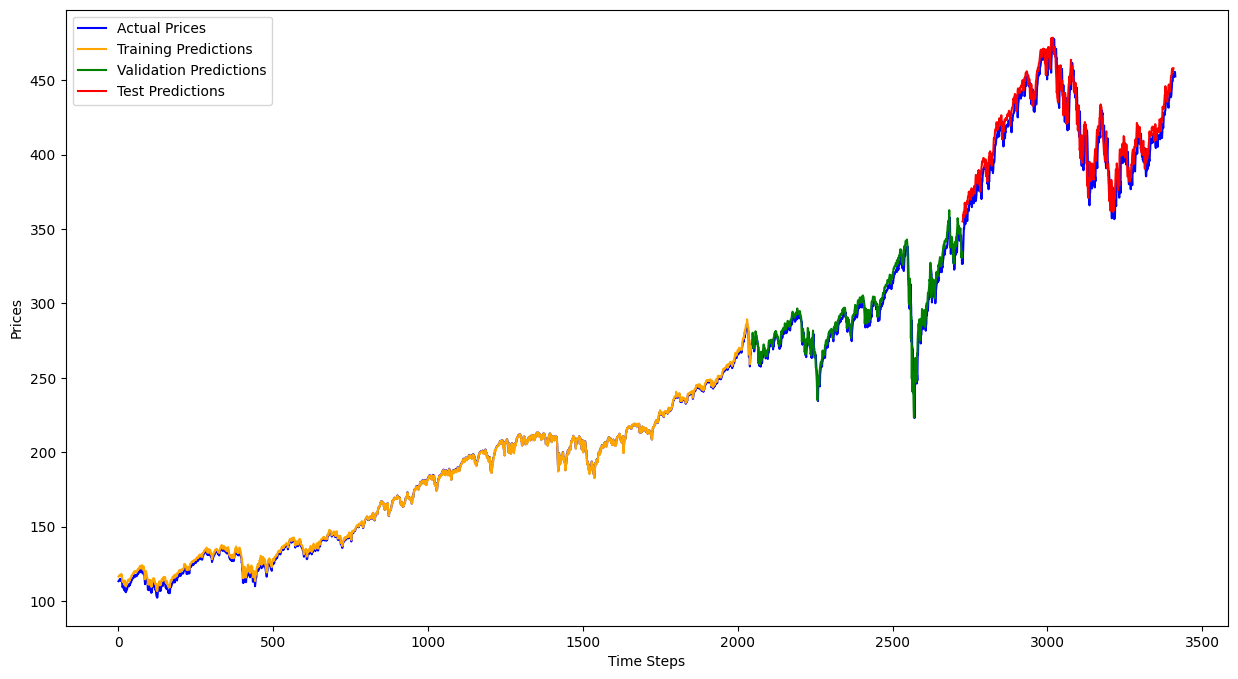

In [15]:
# Call the function with appropriate data
plot_predictions(train_rescaled, val_rescaled, train_predict, val_predict, test_rescaled, test_predict)
